In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.style.use('ggplot')
import sklearn


NOTE: Please make sure that the following libraries versions are included 

In [2]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The numpy version is {}.'.format(np.__version__))

The scikit-learn version is 0.23.1.
The pandas version is 0.24.2.
The numpy version is 1.19.2.


## Load Data

### Read Data from CSV File

In [3]:
file_name = 'wind_turbine_data.csv'
df = pd.read_csv(file_name, parse_dates=['TimeStamp'] )
print(df.shape)
df.head()

(26229, 7)


,TimeStamp,Amb_WindSpeed_Avg,Blds_PitchAngle_Avg,Nac_Direction_Avg,Amb_Temp_Avg,Grd_Prod_Pwr_Avg,Amb_WindSpeed_Std
0,2020-01-01 00:00:00,17.3,14.7,227.3,6.0,1815.0,1.7
1,2020-01-01 00:10:00,18.1,15.4,227.3,6.0,1814.9,1.6
2,2020-01-01 00:20:00,15.6,12.6,227.3,6.0,1814.9,1.0
3,2020-01-01 00:30:00,14.1,10.4,227.3,6.0,1814.9,1.2
4,2020-01-01 00:40:00,12.8,8.6,227.3,6.0,1814.8,1.0


# Feature Engineering

### Remove Unnecessary Columns

In [4]:
features_list = ['TimeStamp','Amb_WindSpeed_Avg', 'Blds_PitchAngle_Avg','Nac_Direction_Avg','Amb_Temp_Avg',
                'Grd_Prod_Pwr_Avg','Amb_WindSpeed_Std']
print("Initial Features:",len(features_list))

Initial Features: 7


### Add Time Features
To make the model more accurate

In [5]:
df['day_of_week'] = df['TimeStamp'].dt.dayofweek
df['month_of_year'] = df['TimeStamp'].dt.month
df['hour_of_day'] = df['TimeStamp'].dt.hour

### Add Turbulence intensity
Turbulence intensity (STD/ MEAN) WSPEED, 10min avg data. (5sec)


In [6]:
# division by zero check included
df['turbulence_intensity'] = df['Amb_WindSpeed_Std'].divide(df['Amb_WindSpeed_Avg']).replace((np.inf, -np.inf),(df['Amb_WindSpeed_Avg'],df['Amb_WindSpeed_Avg']))

***

### Data Split

In [7]:
df_train, df_test = train_test_split(df.drop(columns= ['TimeStamp']), shuffle=False, test_size=0.3)
print("Train set:", df_train.shape, '-', "Test set:",df_test.shape )
print("Total Features:", df_train.shape[1])
df_train.head()

Train set: (18360, 10) - Test set: (7869, 10)
Total Features: 10


,Amb_WindSpeed_Avg,Blds_PitchAngle_Avg,Nac_Direction_Avg,Amb_Temp_Avg,Grd_Prod_Pwr_Avg,Amb_WindSpeed_Std,day_of_week,month_of_year,hour_of_day,turbulence_intensity
0,17.3,14.7,227.3,6.0,1815.0,1.7,2,1,0,0.098266
1,18.1,15.4,227.3,6.0,1814.9,1.6,2,1,0,0.088398
2,15.6,12.6,227.3,6.0,1814.9,1.0,2,1,0,0.064103
3,14.1,10.4,227.3,6.0,1814.9,1.2,2,1,0,0.085106
4,12.8,8.6,227.3,6.0,1814.8,1.0,2,1,0,0.078125


In [8]:
# Split DataSet
X_train = df_train.drop(columns=['Grd_Prod_Pwr_Avg'])
y_train = df_train.Grd_Prod_Pwr_Avg

X_test = df_test.drop(columns=['Grd_Prod_Pwr_Avg']) # X-test
y_test = df_test.Grd_Prod_Pwr_Avg                   # y-test

# Model Tunning

In [9]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 3)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
max_leaf_nodes = [5, 20, 100]

In [10]:
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
                'max_leaf_nodes': max_leaf_nodes
}

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
grid_search = RandomizedSearchCV(
                    estimator=DecisionTreeRegressor(), 
                    param_distributions=random_grid,
                    cv=5 , n_jobs=-1, verbose=1)

%time _ = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished


CPU times: user 361 ms, sys: 136 ms, total: 498 ms
Wall time: 2.17 s


### Evaluation Metrics

In [12]:
optimised_forest = _.best_estimator_
y_pred = pd.DataFrame(optimised_forest.predict(X_test))
y_pred.index = X_test.index
y_pred.columns = ['expected_power']
result_df = pd.concat([y_pred,X_test], axis=1)

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MeAE:", median_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MSE: 2839.8868598736235
MAE: 29.736137809011474
MeAE: 17.765317919075017
R2: 0.9936829675018328


# Visualization Results

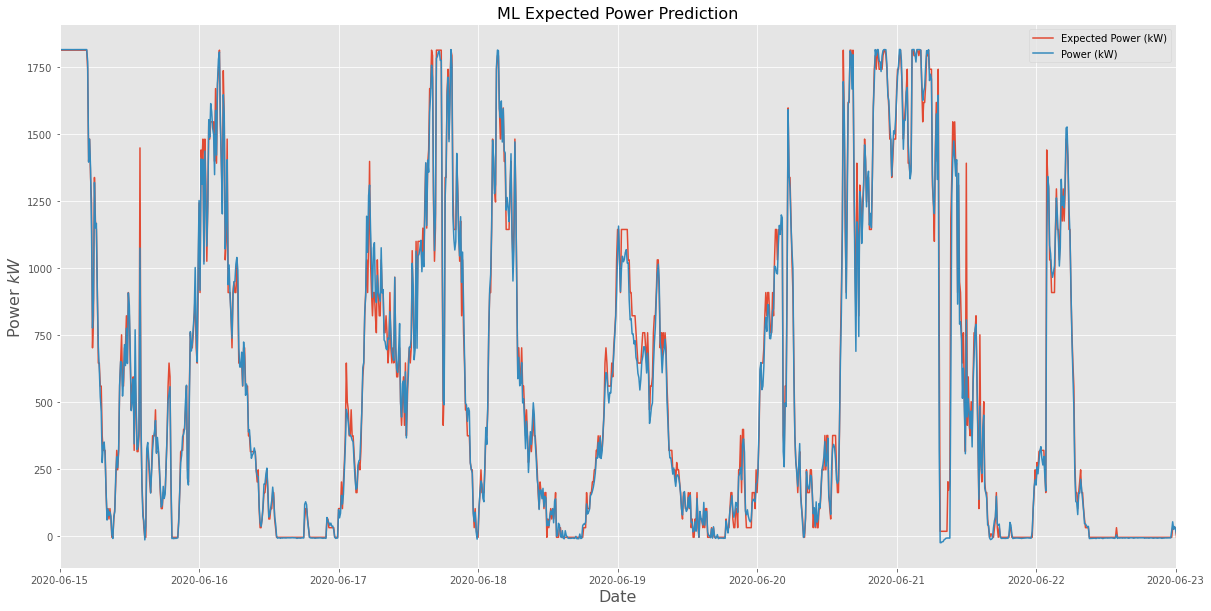

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))


timestamp = df.loc[y_test.index]['TimeStamp']
plt.plot(timestamp, result_df['expected_power'], label='Expected Power (kW)')
plt.plot(timestamp, y_test, label='Power (kW)')
plt.ylabel("Power $kW$", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.title("ML Expected Power Prediction", fontsize=16)
plt.xlim('2020-06-15', '2020-06-23')
plt.legend()